# Udacity Lyft Challenge
## Training script

In [1]:
import os
import time
import glob
import random
import re
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
# Force CPU: uncomment to force CPU - usefull for editing model architecture while another one is training
# Must be done before tensorflow is imported
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
import tensorflow as tf
from keras.models import load_model
from keras.models import model_from_yaml
from keras.applications.mobilenet import MobileNet
from keras.applications import mobilenet
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Activation, Dropout, Add, Flatten, Dense, Reshape, Conv2D, Conv2DTranspose, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras import backend as K
from keras import regularizers
from keras import losses
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import TruncatedNormal
from keras.callbacks import LambdaCallback, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.utils import Sequence

%matplotlib inline

/home/anand/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# To ensure GPU is being used
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14980066422001819313
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7563123098
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3476406077072319794
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Basic Definitions

- defines carla's hood shape for filling in labels
- define base_model_file if training from existing model; set to None to start training from scratch

In [5]:
IMAGE_HT = 576
IMAGE_WD = 800
data_dir = '/home/anand/lyft/CARLA_0.8.2/PythonClient/'
CarlaLabels = {
    "None":0,
    "Buildings":1,
    "Fences":2,
    "Other":3,
    "Pedestrians":4,
    "Poles":5,
    "RoadLines":6,
    "Roads":7,
    "Sidewalks":8,
    "Vegetation":9,
    "Vehicles":10,
    "Walls":11,
    "TrafficSigns":12,
}
CarlaHood = np.array([
        (0,519),
        (110,521),
        (135, 508),
        (383, 498),
        (417,498),
        (665, 508),
        (687, 521),
        (IMAGE_WD,519),
        (IMAGE_WD, IMAGE_HT), 
        (0, IMAGE_HT)])
h = np.ones((IMAGE_HT, IMAGE_WD), dtype=np.uint8)
cv2.fillPoly(h, [CarlaHood], 0)
CarlaHood = h==0

num_classes = 2
model_name = 'mn12_%s' % time.strftime('%m%d')
base_model_file = os.path.join(data_dir, '0_mn6_0601_weights_2.hdf5')
trainingMode = True

## Define model

- Load existing model or define new with pre-trained imagenet weights
- Can specify layer name to freeze till; set FROZEN_LAYERS=0 to train all layers

In [6]:
from keras.utils.data_utils import get_file

# Load model if available on disk
if base_model_file != None:
    if not os.path.exists(os.path.join(base_model_file)):
        raise Exception('base model not found')
    model = load_model(base_model_file, compile=False, custom_objects={
                   'relu6': mobilenet.relu6,
                   'DepthwiseConv2D': mobilenet.DepthwiseConv2D})
else:
    trainingMode = True
    base_model = MobileNet(include_top=False, weights=None, input_shape=(IMAGE_HT, IMAGE_WD, 3))
    
    BASE_WEIGHT_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.6/'
    root_model_name = 'mobilenet_1_0_224_tf_no_top.h5'
    weights_path = BASE_WEIGHT_PATH + root_model_name
    weights_path = get_file(root_model_name,
                            weights_path,
                            cache_subdir='models')
    base_model.load_weights(weights_path)
    base_model.summary()
    
    regularizer = regularizers.l2(0.01)
    x = base_model.output
    x = Conv2D(filters=num_classes, kernel_size=1, strides=1, padding='SAME',
               kernel_regularizer=regularizer, kernel_initializer='random_uniform', bias_initializer='zeros')(x)

    #conv_pw_5_relu (Activation)  (None, 72, 100, 256)
    x = Conv2DTranspose(filters=256, kernel_size=8, strides=4, padding='SAME',
               kernel_regularizer=regularizer, kernel_initializer='random_uniform', bias_initializer='zeros')(x)
    y = Dropout(0.5)(base_model.get_layer('conv_pw_5_relu').output)
    x = Add()([x, y])
    
    #conv_pw_3_relu (Activation)  (None, 144, 200, 128)
    x = Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding='SAME',
               kernel_regularizer=regularizer, kernel_initializer='random_uniform', bias_initializer='zeros')(x)
    y = Dropout(0.5)(base_model.get_layer('conv_pw_3_relu').output)
    x = Add()([x, y])

    #conv_pw_1_relu (Activation)  (None, 288, 400, 64) 
    x = Conv2DTranspose(filters=64, kernel_size=4, strides=2, padding='SAME',
               kernel_regularizer=regularizer, kernel_initializer='random_uniform', bias_initializer='zeros')(x)
    y = Dropout(0.5)(base_model.get_layer('conv_pw_1_relu').output)
    x = Add()([x, y])

    logits = Conv2DTranspose(filters=num_classes, kernel_size=4, strides=2, padding='SAME', activation='sigmoid',
               kernel_regularizer=regularizer, kernel_initializer='random_uniform', bias_initializer='zeros')(x)

    #logits = Reshape((-1, num_classes))(x)
    model = Model(inputs=base_model.input, outputs=logits)

# Freeze layers
FROZEN_LAYERS = [idx for idx,x in enumerate(model.layers) if x.name=='conv_pw_13_relu'][0]
print('Trainable after %s' % model.layers[FROZEN_LAYERS].name)
for idx,layer in enumerate(model.layers):
    layer.trainable = (idx > FROZEN_LAYERS)

Trainable after conv_pw_13_relu


## Dice Coefficient and Loss function

In [7]:
def dice_layer(y_true_layer, y_pred_layer):
    intersection = K.sum(y_true_layer * y_pred_layer)
    return (2. * intersection + 1.) / (K.sum(y_true_layer) + K.sum(y_pred_layer) + 1.)
    
def dice_coef0(y_true, y_pred):
    return dice_layer(y_true[:,:,:,0], y_pred[:,:,:,0])

def dice_coef1(y_true, y_pred):
    return dice_layer(y_true[:,:,:,1], y_pred[:,:,:,1])

def dice_coef_loss(y_true, y_pred):
    return 3.0 - (dice_coef0(y_true, y_pred) + (2.0 * dice_coef1(y_true, y_pred)))

## IOU metric and Loss function

In [8]:
def iou_layer(y_true_layer, y_pred_layer):
    intersection = K.sum(y_true_layer * y_pred_layer)
    return (intersection + 1.) / (K.sum(y_true_layer) + K.sum(y_pred_layer) - intersection + 1.)

def iou0(y_true, y_pred):
    return iou_layer(y_true[:,:,:,0], y_pred[:,:,:,0])

def iou1(y_true, y_pred):
    return iou_layer(y_true[:,:,:,1], y_pred[:,:,:,1])

def iou_loss(y_true, y_pred):
    return 3.0 - (iou0(y_true, y_pred) + (2.0 * iou1(y_true, y_pred)))

## Metrics and Loss function

- False positive, negative and F1 score metrics and loss functions

In [9]:
# Metrics
def fp(y_true_layer, y_pred_layer):
    intersection = K.sum(y_true_layer * y_pred_layer)
    return K.sum(y_pred_layer) - intersection

def fn(y_true_layer, y_pred_layer):
    intersection = K.sum(y_true_layer * y_pred_layer)
    return K.sum(y_true_layer) - intersection

def fp0(y_true, y_pred):
    return fp(y_true[:,:,:,0], y_pred[:,:,:,0])

def fp1(y_true, y_pred):
    return fp(y_true[:,:,:,1], y_pred[:,:,:,1])

def fn0(y_true, y_pred):
    return fn(y_true[:,:,:,0], y_pred[:,:,:,0])

def fn1(y_true, y_pred):
    return fn(y_true[:,:,:,1], y_pred[:,:,:,1])

def precision_layer(y_true_layer, y_pred_layer):
    intersection = K.sum(y_true_layer * y_pred_layer)
    return intersection / (K.sum(y_pred_layer) + 1.)

def recall_layer(y_true_layer, y_pred_layer):
    intersection = K.sum(y_true_layer * y_pred_layer)
    return intersection / (K.sum(y_true_layer) + 1.)

def precision0(y_true, y_pred):
    return precision_layer(y_true[:,:,:,0], y_pred[:,:,:,0])

def precision1(y_true, y_pred):
    return precision_layer(y_true[:,:,:,1], y_pred[:,:,:,1])

def recall0(y_true, y_pred):
    return recall_layer(y_true[:,:,:,0], y_pred[:,:,:,0])

def recall1(y_true, y_pred):
    return recall_layer(y_true[:,:,:,1], y_pred[:,:,:,1])

def carf(y_true, y_pred):
    presci = precision1(y_true, y_pred)
    recall = recall1(y_true, y_pred)
    return (1+4)*(presci * recall)/(4*presci + recall)

def roadf(y_true, y_pred):
    presci = precision0(y_true, y_pred)
    recall = recall0(y_true, y_pred)
    return (1+0.25)*(presci * recall)/(0.25*presci + recall)

def avgf(y_true, y_pred):
    return (carf(y_true, y_pred) + roadf(y_true, y_pred)) / 2.0

def avgf_loss(y_true, y_pred):
    return 10.0 * (1 - roadf(y_true, y_pred)) +  30.0 * (1 - carf(y_true, y_pred))

# Loss
def fpfn_layer(y_true_layer, y_pred_layer, fpnw=[1.,1.]):
    intersection = K.sum(y_true_layer * y_pred_layer)
    return (fpnw[0] * (K.sum(y_pred_layer) - intersection)) + (fpnw[1] * (K.sum(y_true_layer) - intersection))

def fpfn0(y_true, y_pred, fpnw=[1.,1.]):
    return fpfn_layer(y_true[:,:,:,0], y_pred[:,:,:,0], fpnw)

def fpfn1(y_true, y_pred, fpnw=[1.,1.]):
    return fpfn_layer(y_true[:,:,:,1], y_pred[:,:,:,1], fpnw)

def fpfn_loss(y_true, y_pred):
    return fpfn0(y_true, y_pred, [1., 2.]) + (3.0 * fpfn1(y_true, y_pred, [1.25, 1.]))

## Compile model with optimizer

In [10]:
# compile the model (should be done *after* setting layers to non-trainable)
learning_rate = 1e-3
model.compile(optimizer=SGD(lr=learning_rate, momentum=0.9, nesterov=True), loss=avgf_loss, metrics=[precision0, recall0, precision1, recall1, roadf, carf, avgf])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 576, 800, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 578, 802, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 288, 400, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 288, 400, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

## Image data accessors

In [11]:
def getLabelFrames(seg_file):
    seg = cv2.imread(seg_file)[0:IMAGE_HT, 0:IMAGE_WD, :]
    if np.any(seg[:,:,0:2] != 0):
        raise Exception('bad seg data: non zero values in channel 1 & 2')
    seg = seg[:,:,2]
    vehicle_frame = np.zeros(seg.shape)
    road_frame = np.zeros(seg.shape)

    road = np.logical_or(seg==CarlaLabels['Roads'], seg==CarlaLabels['RoadLines'])
    vehicles = seg==CarlaLabels['Vehicles']
    road_frame[road] = 1
    vehicle_frame[vehicles] = 1
    vehicle_frame[CarlaHood] = 0
    return (road_frame, vehicle_frame)

def getImage(img_file):
    x = cv2.imread(img_file)[0:IMAGE_HT, 0:IMAGE_WD, :]
    cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

## Training and Validation Sets

- Sequence class to wrap file list and serve out image & label data

Training data size: 83130 


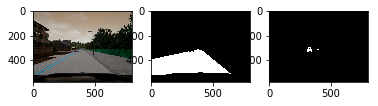

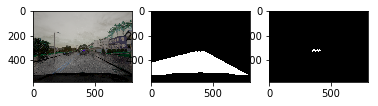

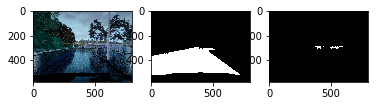

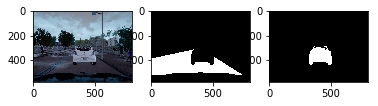

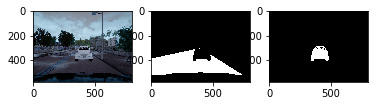

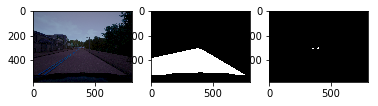

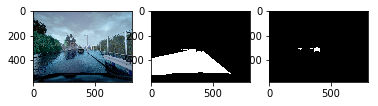

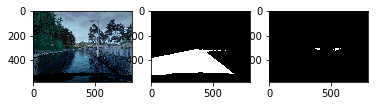

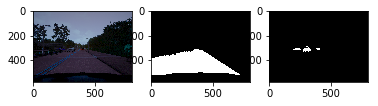

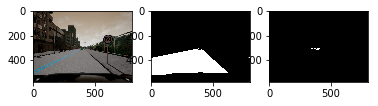

In [12]:
label_list1 = [] #glob.glob(os.path.join(data_dir, 'Train-old/CameraSeg/*0.png')) + glob.glob(os.path.join(data_dir, 'Train-old/CameraSeg/*5.png'))

with open('75000.txt', 'r') as train_list:
    label_list = [x.strip() for x in train_list if x.strip() not in label_list1]

label_list = label_list1 + label_list
print("Training data size: %d " % len(label_list))
num_labels = len(label_list)
np.random.shuffle(label_list)

#val_size = num_labels*20//100
# if val_size > 3000:
#     val_size = 3000
# train_y = label_list[val_size:]
# test_y = label_list[0:val_size]
# print("Training set: {0}, Test set: {1}".format(len(train_y), len(test_y)))
# train_x = [re.sub('CameraSeg', 'CameraRGB', x) for x in train_y]
# test_x = [re.sub('CameraSeg', 'CameraRGB', x) for x in test_y]

train_y = label_list
train_x = [re.sub('CameraSeg', 'CameraRGB', x) for x in train_y]

test_y = glob.glob(os.path.join('./data/', 'Train/CameraSeg/*.png'))
np.random.shuffle(test_y)
test_x = [re.sub('CameraSeg', 'CameraRGB', x) for x in test_y]

for i in range(10):
    x = getImage(test_x[i])
    road_frame, vehicle_frame = getLabelFrames(test_y[i])
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(x)
    plt.subplot(1,3,2)
    plt.imshow(road_frame, cmap='gray')
    plt.subplot(1,3,3)
    plt.imshow(vehicle_frame, cmap='gray')
    plt.show()

class DataGenerator(Sequence):

    def __init__(self, x, y, batch_size, input_preprocessor):
        self.y = y
        self.x = x
        self.batch_size = batch_size
        self.input_preprocessor = input_preprocessor
        self.minidx = 1e+10
        self.maxidx = -1e+10

    def getResetIdx(self):
        min_idx = self.minidx
        max_idx = self.maxidx
        self.minidx = 1e+10
        self.maxidx = -1e+10
        return (min_idx,max_idx)       

    def __len__(self):
        return math.ceil(len(self.x) / float(self.batch_size))

    def inputimage(self, file_name):
        return self.input_preprocessor(getImage(file_name).astype(np.float32))

    def labelread(self, file_name):
        tup = getLabelFrames(file_name)
        if num_classes > 1:
            label = np.dstack(tup)
        else:
            label = tup[1]
        return label#.reshape(-1, num_classes)

    def __getitem__(self, idx):
        if idx < self.minidx:
            self.minidx = idx
        if idx > self.maxidx:
            self.maxidx = idx
        batch_x = self.x[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size: (idx + 1) * self.batch_size]
        return np.array([self.inputimage(file_name) for file_name in batch_x]), np.array([self.labelread(file_name) for file_name in batch_y])


#### Pre-process image data

In [13]:
def preprocess_input(x):
    return (x / 127.5) - 1.

batch_size = 30
train_gen = DataGenerator(train_x, train_y, batch_size, input_preprocessor = preprocess_input)
val_gen = DataGenerator(test_x, test_y, batch_size, input_preprocessor = preprocess_input)

## Training

- Collects metrics
- Logs to tensorboard
- Checkpoints weights

In [14]:
if trainingMode:
    steps_per_epoch = 4000 // batch_size
    epochs_for_1pass = len(train_gen) // steps_per_epoch
    epochs = 1 * epochs_for_1pass
    print("Training for: {0} epochs, {1} steps each, {2} images per step".format(epochs, steps_per_epoch, batch_size))
    checkpoint_file = os.path.join(data_dir, '%s-{epoch:02d}-{avgf:.2f}.hdf5' % (model_name))
    saveWeights = ModelCheckpoint(filepath=checkpoint_file, verbose=1, save_best_only=True)
    tensorboardLog = TensorBoard(log_dir='./logs/%s' % model_name)
    #train_gen_indexes = LambdaCallback(on_epoch_end=lambda batch,logs: print("trained on index range: {}".format(train_gen.getResetIdx())))
    lradjust = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.3, patience=5, verbose=1, cooldown=2, min_lr=1e-10)
    #lradjust = LearningRateScheduler(schedule=lambda e: 1e-3 * (0.1**(e // epochs_for_1pass)), verbose=1 )
    model.fit_generator(train_gen, validation_data = val_gen, 
                        epochs=epochs, steps_per_epoch=steps_per_epoch,
                        callbacks=[saveWeights, tensorboardLog, lradjust],
                        shuffle=True, use_multiprocessing=True, workers = 3)

Training for: 20 epochs, 133 steps each, 30 images per step
Epoch 1/20
133/133 [==============================] - 343s 3s/step - loss: 1.5354 - precision0: 0.9978 - recall0: 0.9703 - precision1: 0.9091 - recall1: 0.9697 - roadf: 0.9922 - carf: 0.9569 - avgf: 0.9745 - val_loss: 2.1791 - val_precision0: 0.9975 - val_recall0: 0.9735 - val_precision1: 0.8777 - val_recall1: 0.9509 - val_roadf: 0.9926 - val_carf: 0.9353 - val_avgf: 0.9639

Epoch 00001: val_loss improved from inf to 2.17914, saving model to /home/anand/lyft/CARLA_0.8.2/PythonClient/mn12_0604-01-0.97.hdf5
Epoch 2/20
133/133 [==============================] - 272s 2s/step - loss: 1.5389 - precision0: 0.9978 - recall0: 0.9701 - precision1: 0.9088 - recall1: 0.9696 - roadf: 0.9921 - carf: 0.9568 - avgf: 0.9745 - val_loss: 2.1802 - val_precision0: 0.9975 - val_recall0: 0.9736 - val_precision1: 0.8790 - val_recall1: 0.9505 - val_roadf: 0.9926 - val_carf: 0.9353 - val_avgf: 0.9639

Epoch 00002: val_loss did not improve from 2.17914


133/133 [==============================] - 264s 2s/step - loss: 1.5571 - precision0: 0.9977 - recall0: 0.9699 - precision1: 0.9065 - recall1: 0.9695 - roadf: 0.9920 - carf: 0.9562 - avgf: 0.9741 - val_loss: 2.1796 - val_precision0: 0.9974 - val_recall0: 0.9737 - val_precision1: 0.8806 - val_recall1: 0.9500 - val_roadf: 0.9926 - val_carf: 0.9352 - val_avgf: 0.9639

Epoch 00019: val_loss did not improve from 2.17854
Epoch 20/20
133/133 [==============================] - 262s 2s/step - loss: 1.5474 - precision0: 0.9976 - recall0: 0.9708 - precision1: 0.9079 - recall1: 0.9694 - roadf: 0.9922 - carf: 0.9565 - avgf: 0.9743 - val_loss: 2.1801 - val_precision0: 0.9975 - val_recall0: 0.9735 - val_precision1: 0.8808 - val_recall1: 0.9499 - val_roadf: 0.9926 - val_carf: 0.9352 - val_avgf: 0.9639

Epoch 00020: val_loss did not improve from 2.17854


## Test trained model

1000/1000 [==============================] - 37s 37ms/step
Loss: 5.4275, preci0:0.9975 recall0: 0.9733, preci1: 0.7917, recall1:0.8388, roadf:0.9925, carf:0.8270, avgf:0.8270


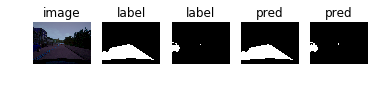

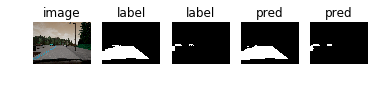

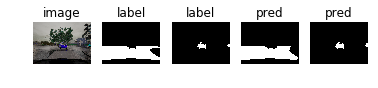

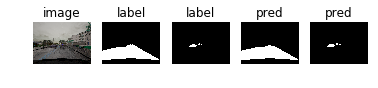

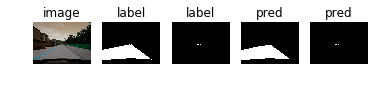

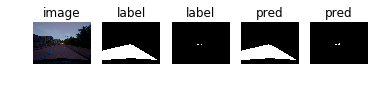

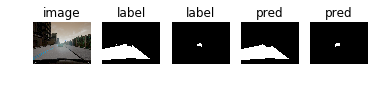

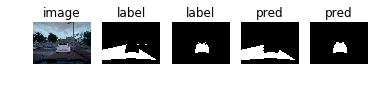

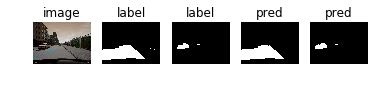

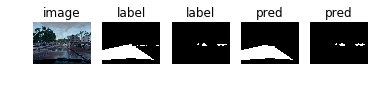

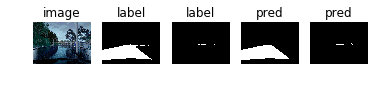

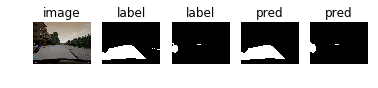

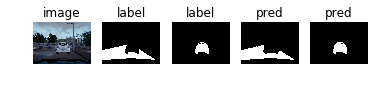

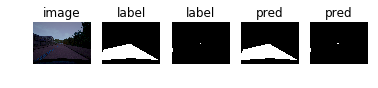

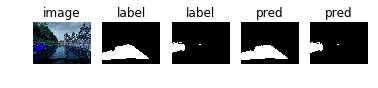

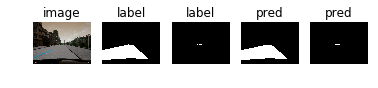

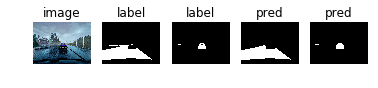

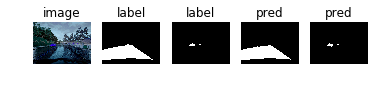

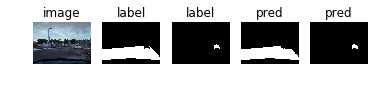

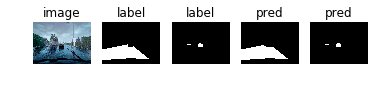

In [15]:
test_y = glob.glob(os.path.join('./data/', 'Train/CameraSeg/*.png'))
np.random.shuffle(test_y)
test_x = [re.sub('CameraSeg', 'CameraRGB', x) for x in test_y]
test_gen = DataGenerator(test_x, test_y, 1, input_preprocessor = preprocess_input)

result = model.evaluate_generator(test_gen, max_queue_size=10, workers=3, use_multiprocessing=True, verbose=1)
print("Loss: {0:.4f}, preci0:{1:.4f} recall0: {2:.4f}, preci1: {3:.4f}, recall1:{4:.4f}, roadf:{5:.4f}, carf:{6:.4f}, avgf:{6:.4f}".format(*result))

avg_loss = 0
avg_dc0 = 0
avg_dc1 = 0
for idx in range(0,20):
    X, label = test_gen[idx]
    pred = model.predict(X)
    pred = np.squeeze(pred)
    pred = np.rint(pred).astype(np.float32)
    label = np.squeeze(label).astype(np.float32)

    plt.figure()
    num_imgs = 1 + (2*num_classes)
    
    img = getImage(test_gen.x[idx])
    ax = plt.subplot(1, num_imgs, 1)
    plt.axis('off')
    plt.imshow(img)
    ax.set_title('image')
    
    for lidx in range(num_classes):
        ax=plt.subplot(1, num_imgs, 2 + lidx)
        plt.axis('off')
        plt.imshow(label[:,:,lidx], cmap='gray')
        ax.set_title('label')

    for pidx in range(num_classes):
        ax=plt.subplot(1, num_imgs, 2 + num_classes + pidx)
        plt.axis('off')
        plt.imshow(pred[:,:,pidx], cmap='gray')
        ax.set_title('pred')


## Export final model

- HDF5 for Keras
- Protobuf pb,pbtxt for TensorFlow

In [16]:
if trainingMode:
#     train_y = glob.glob(os.path.join('./data/', 'Train/CameraSeg/*.png'))
#     np.random.shuffle(train_y)
#     train_x = [re.sub('CameraSeg', 'CameraRGB', x) for x in train_y]
#     train_gen = DataGenerator(train_x, train_y, batch_size, input_preprocessor = preprocess_input)
#     model.fit_generator(train_gen, 
#                         epochs=1, callbacks=[saveWeights], 
#                         shuffle=True, use_multiprocessing=True, workers = 3)
    iteration = 0
    final_model_file = os.path.join(data_dir, '%d_%s_weights_%d.hdf5' % (iteration, model_name, num_classes))
    while os.path.exists(final_model_file):
        iteration += 1
        final_model_file = os.path.join(data_dir, '%d_%s_weights_%d.hdf5' % (iteration, model_name, num_classes))
    model.save(final_model_file, overwrite=True)

In [17]:
import tensorflow as tf
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from tensorflow.tools.graph_transforms import TransformGraph

num_output = 1
output_node_prefix = 'output_node'

pred = [None]*num_output
pred_node_names = [None]*num_output
for i in range(num_output):
    pred_node_names[i] = output_node_prefix+str(i)
    pred[i] = tf.identity(model.outputs[i], name=pred_node_names[i])
print('output nodes names are: ', pred_node_names)

sess = K.get_session()
out_fldr = os.path.join(data_dir, 'models')
tf.train.write_graph(sess.graph.as_graph_def(), out_fldr, '%s_graph_def.pbtxt' % model_name, as_text=True)
constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)
graph_io.write_graph(constant_graph, out_fldr, '%s_saved_model.pb' % model_name, as_text=False)

transforms = ["quantize_weights", "quantize_nodes"]
transformed_graph_def = TransformGraph(sess.graph.as_graph_def(), [], pred_node_names, transforms)
constant_graph = graph_util.convert_variables_to_constants(sess, transformed_graph_def, pred_node_names)
graph_io.write_graph(constant_graph, out_fldr, '%s_saved_model_quantized.pb' % model_name, as_text=False)

output nodes names are:  ['output_node0']
INFO:tensorflow:Froze 145 variables.
Converted 145 variables to const ops.
INFO:tensorflow:Froze 145 variables.
Converted 145 variables to const ops.


'/home/anand/lyft/CARLA_0.8.2/PythonClient/models/mn12_0604_saved_model_quantized.pb'